In [1]:
!radical-stack


  python               : /Users/mtitov/.miniconda3/envs/stack/bin/python3
  pythonpath           : 
  version              : 3.7.10
  virtualenv           : stack

  radical.analytics    : 1.6.7-v0.1.6.7-51-g2255eae@devel
  radical.gtod         : 1.6.7
  radical.pilot        : 1.10.0
  radical.saga         : 1.8.0
  radical.utils        : 1.9.0



In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [3]:
import os

import radical.analytics as ra
import radical.utils     as ru

In [4]:
SID            = 'rp.session.login5.matitov.018970.0001'
SID_PATH       = '../data/%s' % SID
PLOT_NAME_BASE = '.'.join(SID.rsplit('.', 2)[1:])
OUTPUT_DIR     = '../plots'

DESCRIPTION    = '256 DVMs'

X_LIMITS = [0, 3000]

In [5]:
%%capture --no-display

session = ra.Session(SID_PATH, 'radical.pilot')

s_info      = {'p'      : session.filter(etype='pilot', inplace=False),
               't'      : session.filter(etype='task', inplace=False)}
s_info.update({'pid'    : s_info['p'].list('uid')[0],
               'n_tasks': len(s_info['t'].get())})
s_info.update({'n_cores': s_info['p'].get(uid=s_info['pid'])[0].description['cores'],
               'n_gpus' : s_info['p'].get(uid=s_info['pid'])[0].description['gpus'],
               'cores_per_node': s_info['p'].get(uid=s_info['pid'])[0].
                   cfg['resource_details']['rm_info']['cores_per_node']})
s_info.update({'n_nodes': int(s_info['n_cores'] / s_info['cores_per_node'])})

In [6]:
pilot = session.get(uid=s_info['pid'])[0]
PILOT_START_TIME = pilot.timestamps(event={ru.EVENT: 'bootstrap_0_start'})[0]

# Concurrency plot

In [7]:
events = {'Task scheduling': [{ru.STATE: 'AGENT_SCHEDULING'},
                              {ru.EVENT: 'schedule_ok'}],
          'Task execution' : [{ru.EVENT: 'exec_start'},
                              {ru.EVENT: 'exec_stop'}]}

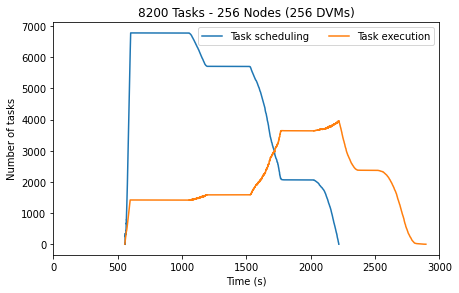

In [8]:
%%capture --no-display

time_series = {e: session.concurrency(event=events[e]) for e in events}
fig, ax     = plt.subplots(figsize=(ra.get_plotsize(500)))

for name in time_series:
    ax.plot([e[0] - PILOT_START_TIME for e in time_series[name]],
            [e[1] for e in time_series[name]],
            label=ra.to_latex(name))

ax.set_xlim(X_LIMITS)

ax.set_title('%s Tasks - %s Nodes (%s)' % (s_info['n_tasks'], s_info['n_nodes'], DESCRIPTION))
ax.legend(ncol=2, loc='upper right')
ax.set_ylabel('Number of tasks')
ax.set_xlabel('Time (s)')

fig.savefig(os.path.join(OUTPUT_DIR, '%s.concurrency.png' % PLOT_NAME_BASE))

# Utilization plot(s)

In [9]:
def utilization_plot(rtype=None):

    rtype = rtype or 'cpu'

    metrics = [
        ['Bootstrap', ['boot', 'setup_1'], '#c6dbef'],
        ['Warmup',    ['warm'], '#f0f0f0'],
        ['Schedule',  ['exec_queue', 'exec_prep', 'unschedule'], '#c994c7'],
        ['Exec RP',   ['exec_rp', 'exec_sh', 'term_sh', 'term_rp'], '#fdbb84'],
        ['Exec Cmd',  ['exec_cmd'], '#e31a1c'],
        ['Cooldown',  ['drain'], '#addd8e']
    ]

    exp = ra.Experiment([SID_PATH], stype='radical.pilot')
    provided, consumed, stats_abs, stats_rel, info = exp.utilization(
        metrics=metrics, rtype=rtype)

    # get the start time of each pilot
    p_zeros = ra.get_pilots_zeros(exp)
    fig, ax = plt.subplots(figsize=(ra.get_plotsize(500)))

    # generate the subplot with labels
    legend, patches, x, y = ra.get_plot_utilization(
        metrics, consumed, p_zeros[SID][s_info['pid']], SID)

    # place all the patches, one for each metric, on the axes
    for patch in patches:
        ax.add_patch(patch)
    
    ax.set_title('%s Tasks - %s Nodes (%s)' % (s_info['n_tasks'], s_info['n_nodes'], DESCRIPTION))

    #ax.set_xlim([x['min'], x['max']])
    ax.set_xlim(X_LIMITS)
    ax.set_ylim([y['min'], y['max']])
    ax.yaxis.set_major_locator(mticker.MaxNLocator(5))
    ax.xaxis.set_major_locator(mticker.MaxNLocator(5))

    if rtype == 'cpu':
        # Specific to Summit when using SMT=4 (default)
        ax.yaxis.set_major_formatter(
            mticker.FuncFormatter(lambda z, pos: int(z / 4)))

    ax.legend(legend, [m[0] for m in metrics],
              loc='upper center', bbox_to_anchor=(0.45, 1.175), ncol=6)
    if rtype == 'cpu':
        ax.set_ylabel('Number of CPU cores')
    elif rtype == 'gpu':
        ax.set_ylabel('Number of GPUs')
    ax.set_xlabel('Time (s)')

    # save plot to PNG file
    fig.savefig(os.path.join(OUTPUT_DIR, '%s.%s.utilization.png' % (PLOT_NAME_BASE, rtype)))

### CPU

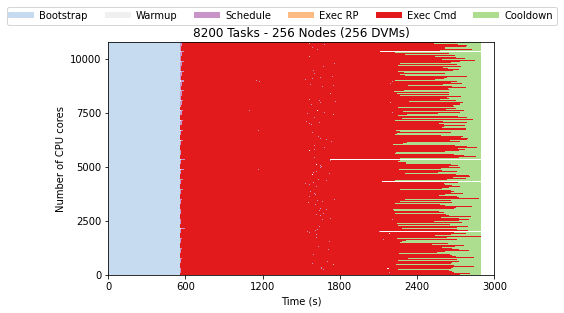

In [10]:
%%capture --no-display

utilization_plot(rtype='cpu')

### GPU

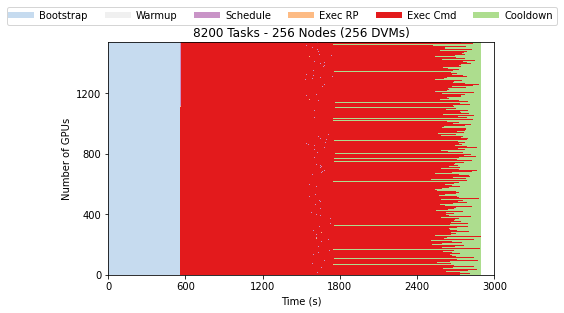

In [11]:
%%capture --no-display

utilization_plot(rtype='gpu')